<a href="https://colab.research.google.com/github/ph-tech/Bayesian-Logistic-regression/blob/main/Copy_of_Unit_2__P2_Bayesian_Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# bayesian_logistic_regression.py
# Minimal dependencies: numpy, scipy

import numpy as np
from scipy.optimize import minimize
from scipy.special import expit  # sigmoid


class BayesianLogisticRegression:
    """
    Bayesian Logistic Regression (BLR) with a zero-mean Gaussian prior on weights
    and a Laplace approximation to the posterior:
        w ~ N(0, alpha^{-1} I)

    After fitting, we approximate:
        p(w | D) ~ N(w_map, Sigma)
    where Sigma = (H + alpha I)^{-1} and H is the data Hessian of the negative log-likelihood.

    Parameters
    ----------
    alpha : float
        Prior precision (L2 strength). Larger alpha = stronger shrinkage.
    add_intercept : bool
        If True, automatically augments X with an intercept term (column of ones).
    tol : float
        Convergence tolerance for optimizer.
    max_iter : int
        Maximum iterations for optimizer.

    Notes
    -----
    Predictive probability integrates the sigmoid over a Gaussian in w^T x.
    We use the widely used approximation:
        E_{z ~ N(mu, s^2)}[sigmoid(z)] ≈ sigmoid( mu / sqrt(1 + (pi * s^2) / 8) )
    (MacKay, 1992; Jaakkola & Jordan bound variants)
    """

    def __init__(self, alpha=1.0, add_intercept=True, tol=1e-6, max_iter=200):
        self.alpha = float(alpha)
        self.add_intercept = bool(add_intercept)
        self.tol = float(tol)
        self.max_iter = int(max_iter)
        self.w_map_ = None
        self.Sigma_ = None  # posterior covariance
        self.success_ = None
        self.n_iter_ = None

    # ---------- utilities ----------
    def _augment_intercept(self, X):
        if not self.add_intercept:
            return X
        if X.ndim != 2:
            X = np.atleast_2d(X)
        ones = np.ones((X.shape[0], 1), dtype=X.dtype)
        return np.hstack([ones, X])

    def _neg_log_post(self, w, X, y):
        """
        Negative log posterior (up to a constant):
            -log p(w|D) = -sum_i log Bernoulli(y_i | sigmoid(x_i^T w)) + (alpha/2) * ||w||^2
        """
        z = X @ w
        # Bernoulli negative log-likelihood (stable)
        # nll = sum( log(1 + exp(z)) - y*z ), but use logaddexp for stability
        nll = np.sum(np.logaddexp(0.0, z) - y * z)
        prior = 0.5 * self.alpha * np.dot(w, w)
        return nll + prior

    def _grad_neg_log_post(self, w, X, y):
        p = expit(X @ w)  # sigmoid
        grad_ll = X.T @ (p - y)          # gradient of NLL
        grad_prior = self.alpha * w
        return grad_ll + grad_prior

    def _hessian_neg_log_post(self, w, X):
        p = expit(X @ w)
        W = p * (1.0 - p)                # diag of weights
        # H = X^T diag(W) X + alpha I
        # compute efficiently without forming full diag matrix
        XW = X * W[:, None]
        H = X.T @ XW
        H += self.alpha * np.eye(X.shape[1])
        return H

    # ---------- API ----------
    def fit(self, X, y, w0=None):
        """
        Fit by maximizing the posterior (i.e., minimizing negative log-posterior),
        then compute the Laplace covariance from the Hessian at w_map.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        y : array-like, shape (n_samples,)
            Binary labels in {0,1}.
        w0 : array-like, optional
            Initial weights; if None, zeros are used.

        Returns
        -------
        self
        """
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        X = self._augment_intercept(X)
        n_features = X.shape[1]

        if w0 is None:
            w0 = np.zeros(n_features)

        # Optimize negative log-posterior
        res = minimize(
            fun=self._neg_log_post,
            x0=w0,
            jac=self._grad_neg_log_post,
            args=(X, y),
            method="Newton-CG",
            hess=lambda w, *args: self._hessian_neg_log_post(w, X),
            options={"xtol": self.tol, "maxiter": self.max_iter}
        )

        self.w_map_ = res.x
        self.success_ = res.success
        self.n_iter_ = res.nit if hasattr(res, "nit") else None

        # Laplace covariance: inverse Hessian at MAP
        H = self._hessian_neg_log_post(self.w_map_, X)
        # Numerical stability: use solve rather than explicit inverse
        self.Sigma_ = np.linalg.inv(H)

        return self

    def predict_proba(self, X, return_std=False):
        """
        Predict class-1 probabilities with uncertainty-aware correction.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        return_std : bool
            If True, also return the standard deviation of the latent z = w^T x.

        Returns
        -------
        p : ndarray, shape (n_samples,)
            Predictive probabilities p(y=1 | x, D).
        (optional) z_std : ndarray, shape (n_samples,)
            Posterior std of the latent z = w^T x, using Laplace covariance.
        """
        if self.w_map_ is None or self.Sigma_ is None:
            raise RuntimeError("Model is not fitted. Call fit(X, y) first.")

        X = np.asarray(X, dtype=float)
        X = self._augment_intercept(X)

        # posterior mean & variance for z = w^T x under Gaussian posterior on w
        mu = X @ self.w_map_
        # var(z) = x^T Sigma x
        z_var = np.einsum("ij,jk,ik->i", X, self.Sigma_, X)
        # MacKay approximation for E[sigmoid(z)]
        denom = np.sqrt(1.0 + (np.pi * z_var) / 8.0)
        p = expit(mu / denom)

        if return_std:
            return p, np.sqrt(z_var)
        return p

    def predict(self, X, threshold=0.5):
        """
        Hard predictions using threshold on predictive probability.
        """
        p = self.predict_proba(X)
        return (p >= threshold).astype(int)

    def sample_weights(self, n_samples=1000, random_state=None):
        """
        Draw samples of weights from the Laplace posterior N(w_map, Sigma).
        """
        if self.w_map_ is None or self.Sigma_ is None:
            raise RuntimeError("Model is not fitted. Call fit(X, y) first.")
        rng = np.random.default_rng(random_state)
        return rng.multivariate_normal(mean=self.w_map_, cov=self.Sigma_, size=n_samples)


# ---------------------- quick usage demo ----------------------
if __name__ == "__main__":
    # Synthetic separable-ish data
    rng = np.random.default_rng(0)
    n, d = 200, 2
    X_raw = rng.normal(size=(n, d))
    true_w = np.array([0.5, -1.2])  # no intercept for data gen
    logits = X_raw @ true_w
    y = rng.binomial(1, expit(logits))

    # Fit BLR
    blr = BayesianLogisticRegression(alpha=2.0, add_intercept=True)
    blr.fit(X_raw, y)

    # Predict on a few points
    X_test = np.array([[0.0, 0.0], [1.0, -1.0], [-1.0, 1.0]])
    p, z_std = blr.predict_proba(X_test, return_std=True)
    print("Predictive p(y=1|x):", p)
    print("Latent std devs:", z_std)

    # Draw posterior weight samples
    W = blr.sample_weights(5, random_state=42)
    print("Weight samples (first 5):\n", W)


Predictive p(y=1|x): [0.49760079 0.82627321 0.17080381]
Latent std devs: [0.15494416 0.32517292 0.31678925]
Weight samples (first 5):
 [[ 0.18583634  0.51552774 -0.98951491]
 [ 0.13531861  0.73500266 -0.70905578]
 [ 0.02973704  0.56528257 -1.00822005]
 [-0.05618435  0.49712756 -1.28460951]
 [-0.12120425  0.41713951 -1.11941525]]


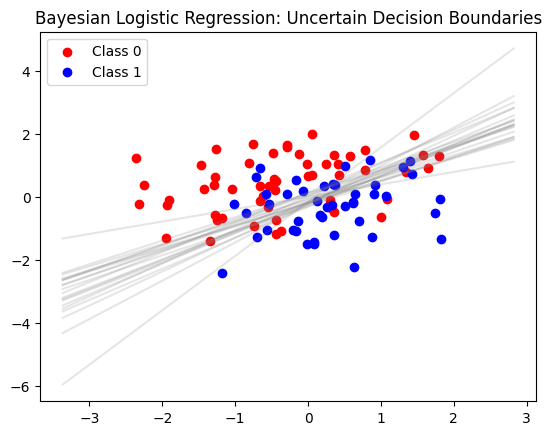

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

# Generate 2D toy dataset
rng = np.random.default_rng(0)
n = 100
X = rng.normal(size=(n, 2))
true_w = np.array([1.0, -1.5])
y = rng.binomial(1, expit(X @ true_w))

# Fit Bayesian logistic regression
blr = BayesianLogisticRegression(alpha=2.0, add_intercept=True)
blr.fit(X, y)

# Sample posterior weights
W_samples = blr.sample_weights(20, random_state=0)

# Plot data
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", label="Class 1")

# Plot multiple decision boundaries
xx = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 50)
for w in W_samples:
    # decision boundary: w0 + w1*x + w2*y = 0
    # here w[0] is intercept
    slope = -w[1]/w[2]
    intercept = -w[0]/w[2]
    yy = slope * xx + intercept
    plt.plot(xx, yy, color="gray", alpha=0.2)

plt.legend()
plt.title("Bayesian Logistic Regression: Uncertain Decision Boundaries")
plt.show()
